<a href="https://colab.research.google.com/github/EvanDevelopments/COVID-19-US-Infection-Visulisation-Week-By-Week-/blob/main/COVID_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **COVID-19 US Infection Visulisation (Week By Week)**

## **Load Data**

In [495]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import mapclassify
import imageio.v2 as imageio
from IPython.display import Image
import os
import joblib
from joblib import Parallel, delayed

data_frame=pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/refs/heads/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv")

**Data Cleaning**

In [496]:
data_frame=data_frame.drop(columns=["UID","iso2","iso3","code3","Country_Region","Lat","Long_","Combined_Key"])
all_date_columns = []
for col in data_frame.columns[3:]:
    try:
        pd.to_datetime(col, format='%m/%d/%y', errors='raise')
        all_date_columns.append(col)
    except ValueError:
        break
if not all_date_columns:
    raise ValueError("No date columns found after initial data cleaning. Check your column drops and data structure.")
print(f"Identified {len(all_date_columns)} date columns to cycle through, from {all_date_columns[0]} to {all_date_columns[-1]}.")

Identified 1143 date columns to cycle through, from 1/22/20 to 3/9/23.


**Map Creation**

In [497]:
United_States = gpd.read_file("/content/sample_data/cb_2018_us_county_500k.shp")
United_States.dropna(subset=['GEOID'], inplace=True)
United_States['FIPS'] = United_States['GEOID'].astype(int)
United_States['geometry'] = United_States.geometry.buffer(0)
United_States = United_States[~United_States.geometry.is_empty]

output_folder = "covid_animation_frames"
os.makedirs(output_folder, exist_ok=True)
print(f"Individual map frames will be saved to: {output_folder}/")

Individual map frames will be saved to: covid_animation_frames/


**Merging Data Set With US Map**

In [498]:
frames_list = []
dates_to_process = all_date_columns[::7]
total_frames = len(dates_to_process)

for i, current_date_column in enumerate(dates_to_process):
    print(f"Processing frame {i+1}/{total_frames} for date: {current_date_column}")


    covid_cases_current_date = data_frame[['FIPS', 'Admin2', 'Province_State', current_date_column]].copy()
    covid_cases_current_date.rename(columns={current_date_column: 'ConfirmedCases'}, inplace=True)
    covid_cases_current_date.dropna(subset=['FIPS'], inplace=True)
    covid_cases_current_date['FIPS'] = covid_cases_current_date['FIPS'].astype(int)
    covid_cases_current_date = covid_cases_current_date.groupby('FIPS')['ConfirmedCases'].sum().reset_index()


    merged_map_data = United_States.merge(covid_cases_current_date, on='FIPS', how='left')
    merged_map_data['ConfirmedCases'] = merged_map_data['ConfirmedCases'].fillna(0)

    fig, ax = plt.subplots(figsize=(19,9))

    merged_map_data.plot(column='ConfirmedCases',
                         cmap='Reds',
                         legend=True,
                         ax=ax,
                         edgecolor='0.8',
                         linewidth=0.8,

                         legend_kwds={'title': f"Confirmed COVID-19 Cases"},
                         scheme='quantiles',
                         k=7)

    ax.set_xlim([-125, -66])
    ax.set_ylim([24, 50])
    ax.set_aspect('equal')
    ax.set_axis_off()

    ax.set_title(f"US County-Level COVID-19 Confirmed Cases (as of {current_date_column})", fontsize=18,)

    frame_filename = os.path.join(output_folder, f"covid_map_{i:04d}.png")
    plt.savefig(frame_filename, dpi=90, bbox_inches='tight')


    frames_list.append(frame_filename)
    plt.close(fig)

Processing frame 1/4 for date: 1/22/20


/usr/local/lib/python3.11/dist-packages/mapclassify/classifiers.py:1767: UserWarning: Not enough unique values in array to form 7 classes. Setting k to 2.
  self.bins = quantile(y, k=k)


Processing frame 2/4 for date: 12/7/20
Processing frame 3/4 for date: 10/23/21
Processing frame 4/4 for date: 9/8/22


**Animation Ouput**


All frames processed. Creating GIF: covid_animation.gif
Animation successfully saved as: covid_animation.gif


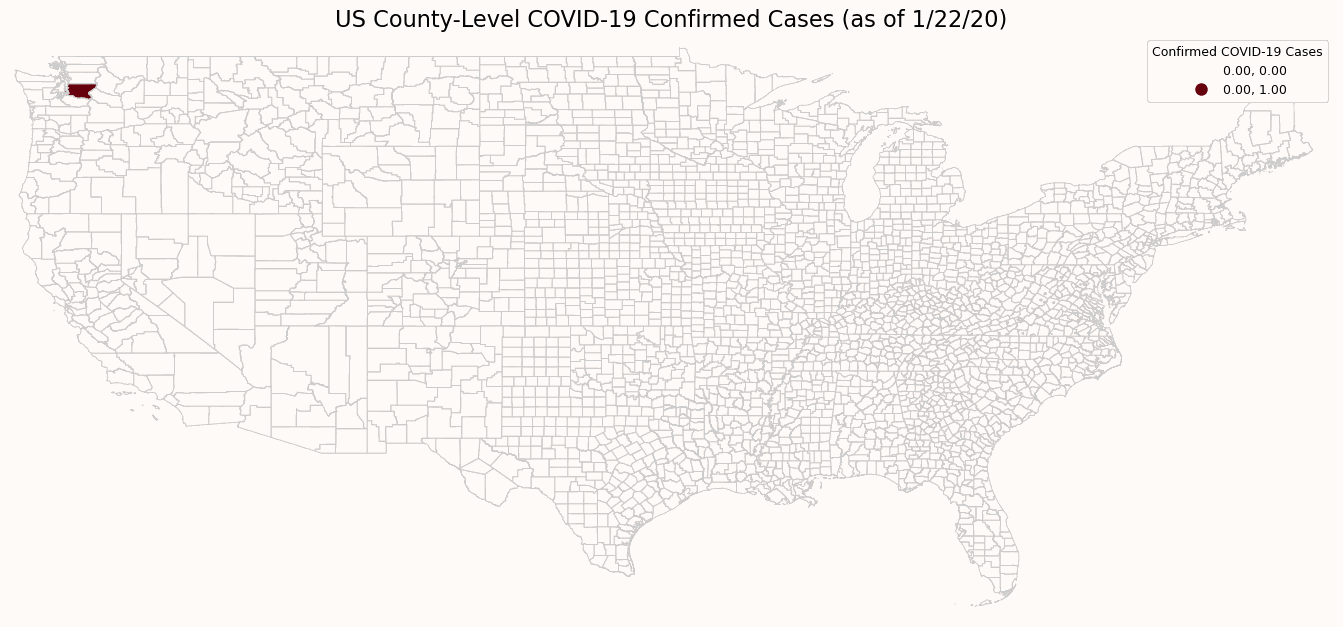

In [499]:
gif_output_path = "covid_animation.gif"
print(f"\nAll frames processed. Creating GIF: {gif_output_path}")

with imageio.get_writer(gif_output_path, mode='I', fps=1) as writer:
    for filename in frames_list:
        image = imageio.imread(filename)
        writer.append_data(image)
        os.remove(filename)

print(f"Animation successfully saved as: {gif_output_path}")

Image(filename=gif_output_path)